In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import time
import psutil
import threading
from memory_profiler import memory_usage

import joblib

/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
df = pd.read_csv('/home/wahba/Documents/nids5/test/dataset/3_Full/attack_and_benign.csv')

selected_features = [
    "Bwd Packet Length Std",
    "Bwd Packet Length Mean",
    "Bwd Packet Length Max",
    "Total Length of Fwd Packets",
    "Fwd Packet Length Max",
    "Fwd Packet Length Mean",
    "Fwd IAT Std",
    "Total Fwd Packets",
    "Fwd Packet Length Std",
    "Flow IAT Max",
    "Flow Bytes/s",
    "Flow IAT Std",
    "Bwd Packet Length Min",
    "Fwd IAT Total",
    "Label",
]

# Keep only the selected features
df = df[selected_features]

# splitting df for training and testing using stratified split
X = df.drop('Label', axis=1) # features
y = df['Label'] # target

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop("Label", axis=1)
y_train = strat_train_set["Label"]

X_test = strat_test_set.drop("Label", axis=1)
y_test = strat_test_set["Label"]

print(pd.DataFrame({
    "count (df)": df["Label"].value_counts(),
    "count (train_set)": strat_train_set["Label"].value_counts(),
    "count (test_set)": strat_test_set["Label"].value_counts(),
    "proportion": strat_train_set["Label"].value_counts(normalize=True),
})
)

        count (df)  count (train_set)  count (test_set)  proportion
Label                                                              
BENIGN     2096134            1676907            419227    0.831152
Attack      425828             340662             85166    0.168848


In [3]:
rbscaler = RobustScaler()

# fit and transform training data, transform testing data
X_train_scaled = rbscaler.fit_transform(X_train)
X_test_scaled = rbscaler.transform(X_test)

joblib.dump(rbscaler, '/home/wahba/Documents/nids5/test/model/binary/robust_scaler.joblib')

['/home/wahba/Documents/nids5/test/model/binary/robust_scaler.joblib']

In [4]:
print(pd.DataFrame({
    "count": y_train.value_counts(),
    "proportion": y_train.value_counts(normalize=True)
})
)

          count  proportion
Label                      
BENIGN  1676907    0.831152
Attack   340662    0.168848


# Undersampling BENIGN

In [5]:
# Initializing the undersampling for the clean df
X_train_resampled, y_train_resampled = RandomUnderSampler(sampling_strategy={'BENIGN': 500000}, random_state=42).fit_resample(X_train, y_train)

# Initializing the undersampling for the scaled df
X_train_resampled_scaled, y_train_resampled_scaled = RandomUnderSampler(sampling_strategy={'BENIGN': 500000}, random_state=42).fit_resample(X_train_scaled, y_train)

In [6]:
print(pd.DataFrame({
    "count": y_train_resampled.value_counts(),
    "proportion": y_train_resampled.value_counts(normalize=True)
})
)

         count  proportion
Label                     
BENIGN  500000    0.594769
Attack  340662    0.405231


# 2. Machine Learning Training

## 2.1. Random Forest

## 2.1.1. Hyperparameter Tuning

In [7]:
'''
# Defining the parameters for the Random Forest Classifier
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

Creating the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Saving results with the standard parameters
cv_sc_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1)
cv_sc_rf = np.mean(cv_sc_rf)

# Apply RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2)
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
print(f'Best Parameters: {random_search_rf.best_params_}')
print(f"Best Cross-Validation Score: {random_search_rf.best_score_}")
print(f"Cross-Validation from Standard: {cv_sc_rf}")

best_params_rf = random_search_rf.best_params_ if random_search_rf.best_score_ > cv_sc_rf else None

del random_search_rf
'''

'\n# Defining the parameters for the Random Forest Classifier\nparam_grid = {\n    \'n_estimators\': [100, 150, 200],\n    \'max_depth\': [20, 30, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\'],\n}\n\nCreating the Random Forest Classifier\nrf_model = RandomForestClassifier(random_state=42, n_jobs=-1)\n\n# Saving results with the standard parameters\ncv_sc_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1)\ncv_sc_rf = np.mean(cv_sc_rf)\n\n# Apply RandomizedSearchCV\nrandom_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2)\nrandom_search_rf.fit(X_train_resampled, y_train_resampled)\n\n# Get the best parameters\nprint(f\'Best Parameters: {random_search_rf.best_params_}\')\nprint(f"Best Cross-Validation Score: {random_search_rf.best_score_}")\nprint(f"Cross-Validation from Standard: {cv_sc_rf}")\n\nbest_

In [8]:
'''
# Defining the parameters for the Random Forest Classifier
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

Creating the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Saving results with the standard parameters
cv_sc_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1)
cv_sc_rf = np.mean(cv_sc_rf)

# Apply RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2)
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
print(f'Best Parameters: {random_search_rf.best_params_}')
print(f"Best Cross-Validation Score: {random_search_rf.best_score_}")
print(f"Cross-Validation from Standard: {cv_sc_rf}")

best_params_rf = random_search_rf.best_params_ if random_search_rf.best_score_ > cv_sc_rf else None

del random_search_rf
'''

'\n# Defining the parameters for the Random Forest Classifier\nparam_grid = {\n    \'n_estimators\': [100, 150, 200],\n    \'max_depth\': [20, 30, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\'],\n}\n\nCreating the Random Forest Classifier\nrf_model = RandomForestClassifier(random_state=42, n_jobs=-1)\n\n# Saving results with the standard parameters\ncv_sc_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1)\ncv_sc_rf = np.mean(cv_sc_rf)\n\n# Apply RandomizedSearchCV\nrandom_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2)\nrandom_search_rf.fit(X_train_resampled, y_train_resampled)\n\n# Get the best parameters\nprint(f\'Best Parameters: {random_search_rf.best_params_}\')\nprint(f"Best Cross-Validation Score: {random_search_rf.best_score_}")\nprint(f"Cross-Validation from Standard: {cv_sc_rf}")\n\nbest_

In [9]:
best_params_rf = {'n_estimators': 150, 
                'min_samples_split': 2, 
                'min_samples_leaf': 2, 
                'max_features': 'sqrt', 
                'max_depth': 30}
cv = 5
n_jobs = -1
random_state = 42

measurement_rf = {}

rf_model = RandomForestClassifier(**best_params_rf, random_state=random_state, n_jobs=n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    rf_model.fit(X_train_resampled, y_train_resampled)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_rf = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_rf['Memory Usage (MB)'] = train_memory_rf
    measurement_rf['Training Time (s)'] = training_time
    measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=cv, n_jobs=n_jobs)

except Exception as e:
    print(f"Error during Random Forest training: {e}")

In [10]:
## 2.1.3. Model evaluation 

In [11]:
### Cross-validation average score

In [12]:
# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_rf = np.mean(cv_scores_rf)
print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')


Cross validation average score: 0.9947 +/- standard deviation: 0.0003


In [13]:
### Accuracy

In [14]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy on the test set: {accuracy_rf:.4f}')

Accuracy on the test set: 0.9964


In [15]:
### Computational Cost

In [16]:
print("Resource measurements:", measurement_rf)

Resource measurements: {'Memory Usage (MB)': 2424.359375, 'Training Time (s)': 63.13440132141113, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 98.82061688311694}


In [17]:
### Confusion Matrix

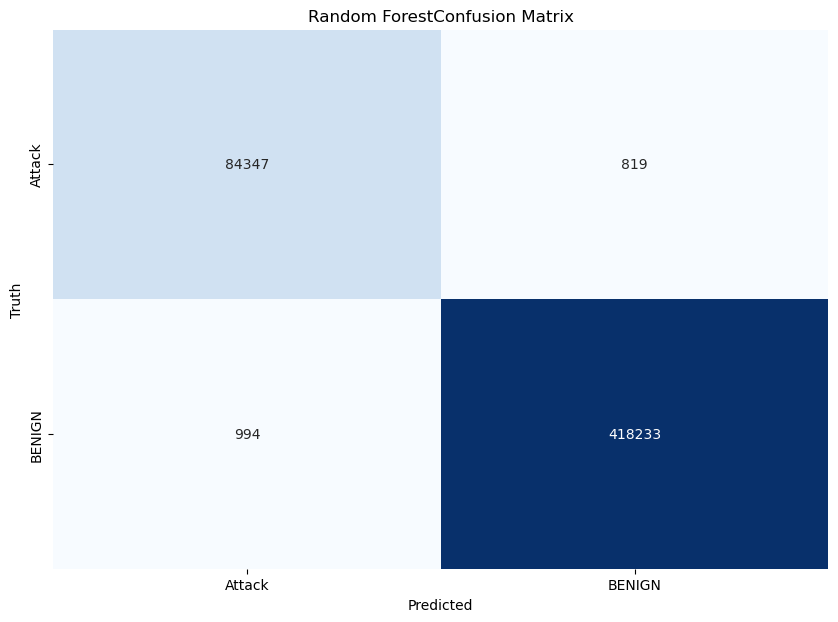

In [18]:
# Evaluating the model via confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Random ForestConfusion Matrix')
plt.show()

In [19]:
### Classification report

In [20]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

      Attack       0.99      0.99      0.99     85166
      BENIGN       1.00      1.00      1.00    419227

    accuracy                           1.00    504393
   macro avg       0.99      0.99      0.99    504393
weighted avg       1.00      1.00      1.00    504393



In [21]:
## 2.1.4 Model Export

In [22]:
joblib.dump(rf_model, '/home/wahba/Documents/nids5/test/model/binary/rf_binary2.joblib')

['/home/wahba/Documents/nids5/test/model/binary/rf_binary2.joblib']

In [23]:
## 2.2. XGBoost

In [24]:
### 2.2.1. Hyperparameter Tuning

In [25]:
### 2.2.1. Hyperparameter Tuning

In [26]:
'''
# Defining the parameter grid for XGBoost
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.2, 0.3, 0.4],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
}

# XGBoost's `multi:softmax` objective requires numerical labels for classification. Therefore, a mapping is necessary to convert categorical labels into numerical values before training the model.
# # Creating the XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train_resampled.unique()), random_state=42, n_jobs=-1)

# Custom mapping for the attack types
label_mapping = {
    'Normal Traffic': 0,
    'DoS': 1,
    'DDoS': 2,
    'Port Scanning': 3,
    'Brute Force': 4,
    'Web Attacks': 5,
    'Bots': 6
}
y_train_resampled_mapped = y_train_resampled.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# Saving results with the standard parameters
cv_sc_xgb = cross_val_score(xgb_model, X_train_resampled, y_train_resampled_mapped, cv=3, n_jobs=-1)
cv_sc_xgb = np.mean(cv_sc_xgb)

# Perform RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=30, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search_xgb.fit(X_train_resampled, y_train_resampled_mapped)

# Best parameters found by RandomizedSearchCV
print(f'Best Parameters for XGBoost: {random_search_xgb.best_params_}')
print(f"Best Cross-Validation Score: {random_search_xgb.best_score_}")
print(f"Cross-Validation from Standard: {cv_sc_xgb}")

best_params_xgb = random_search_xgb.best_params_ if random_search_xgb.best_score_ > cv_sc_xgb else None

del random_search_xgb

'''

'\n# Defining the parameter grid for XGBoost\nparam_dist = {\n    \'n_estimators\': [100, 150, 200],\n    \'max_depth\': [3, 6, 9],\n    \'learning_rate\': [0.2, 0.3, 0.4],\n    \'subsample\': [0.7, 0.8, 1.0],\n    \'colsample_bytree\': [0.7, 0.8, 1.0],\n    \'min_child_weight\': [1, 5, 10],\n}\n\n# XGBoost\'s `multi:softmax` objective requires numerical labels for classification. Therefore, a mapping is necessary to convert categorical labels into numerical values before training the model.\n# # Creating the XGBoost Classifier\nxgb_model = xgb.XGBClassifier(objective=\'multi:softmax\', num_class=len(y_train_resampled.unique()), random_state=42, n_jobs=-1)\n\n# Custom mapping for the attack types\nlabel_mapping = {\n    \'Normal Traffic\': 0,\n    \'DoS\': 1,\n    \'DDoS\': 2,\n    \'Port Scanning\': 3,\n    \'Brute Force\': 4,\n    \'Web Attacks\': 5,\n    \'Bots\': 6\n}\ny_train_resampled_mapped = y_train_resampled.map(label_mapping)\ny_test_mapped = y_test.map(label_mapping)\n\n# Sa

In [27]:
'''
Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best Cross-Validation Score: 0.9990827488980495
Cross-Validation from Standard: 0.9990851282783
'''

"\nBest Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 1.0}\nBest Cross-Validation Score: 0.9990827488980495\nCross-Validation from Standard: 0.9990851282783\n"

In [28]:
# # Creating the XGBoost Classifier
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train_resampled.unique()), random_state=42, n_jobs=-1)

# Custom mapping for the attack types
label_mapping = {
    'BENIGN': 0,
    'Attack': 1,
}
y_train_resampled_mapped = y_train_resampled.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

In [29]:
## 2.2.2. Model Fitting

In [30]:
best_params_xgb = {'subsample': 1.0, 
				'n_estimators': 100, 
				'min_child_weight': 1, 
				'max_depth': 6, 
				'learning_rate': 0.2, 
				'colsample_bytree': 1.0}
cv = 5
n_jobs = -1
random_state = 42

measurement_xgb = {}

xgb_model = xgb.XGBClassifier(**best_params_xgb, 
							objective='multi:softmax', 
							num_class=len(y_train_resampled_mapped.unique()), 
							random_state = random_state, 
							n_jobs = n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    xgb_model.fit(X_train_resampled, y_train_resampled_mapped)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_xgb = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_xgb['Memory Usage (MB)'] = train_memory_rf
    measurement_xgb['Training Time (s)'] = training_time
    measurement_xgb['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_xgb['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_xgb = cross_val_score(xgb_model, X_train_resampled, y_train_resampled_mapped, cv = cv, n_jobs = n_jobs)

except Exception as e:
    print(f"Error during Random Forest training: {e}")

/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' varia

In [31]:
## 2.2.3. Model Evaluation

In [32]:
### Cross-Validation

In [33]:
# Making predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_xgb = np.mean(cv_scores_xgb)
print(f'Cross validation average score: {cv_scores_mean_xgb:.4f} +/- standard deviation: {np.std(cv_scores_xgb):.4f}')

Cross validation average score: 0.9941 +/- standard deviation: 0.0002


In [34]:
### Accuracy

In [35]:
accuracy_xgb = accuracy_score(y_test_mapped, y_pred_xgb)
print(f'Accuracy on the test set: {accuracy_xgb:.4f}')

Accuracy on the test set: 0.9956


In [36]:
### Computational Cost

In [37]:
print("Resource measurements:", measurement_xgb)

Resource measurements: {'Memory Usage (MB)': 2424.359375, 'Training Time (s)': 10.646614789962769, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 99.45283018867924}


In [38]:
### Confusion Matrix

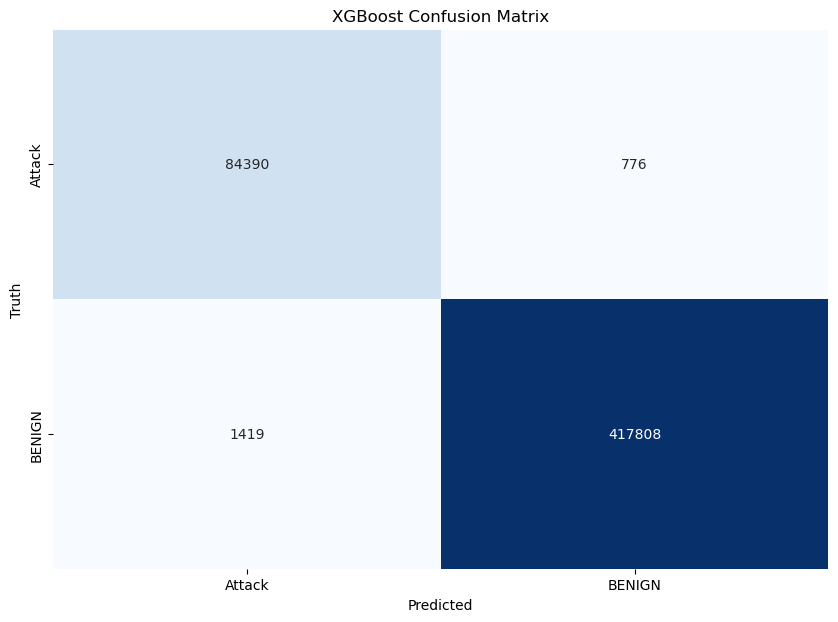

In [39]:
# Remapping the labels for visualization
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels = [reverse_label_mapping[pred] for pred in y_pred_xgb]
actual_labels = sorted([reverse_label_mapping[label] for label in xgb_model.classes_])

# Confusion matrix
cm_xgb = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=actual_labels, yticklabels=actual_labels, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [40]:
### Classification Report

In [41]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

      Attack       0.98      0.99      0.99     85166
      BENIGN       1.00      1.00      1.00    419227

    accuracy                           1.00    504393
   macro avg       0.99      0.99      0.99    504393
weighted avg       1.00      1.00      1.00    504393



In [42]:
### 2.2.3. Exporting model

In [43]:
joblib.dump(xgb_model, '/home/wahba/Documents/nids5/test/model/binary/xgb_binary.joblib')

['/home/wahba/Documents/nids5/test/model/binary/xgb_binary.joblib']

In [44]:
## 2.3. K-Nearest Neighbour (KNN)

In [45]:
### 2.3.1. Hyperparameter Tuning

In [46]:
'''
# Defining the parameters for KNN
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
}

# Creating the KNN model
knn_model = KNeighborsClassifier(n_jobs=-1)

# Saving results with the standard parameters
cv_sc_knn = cross_val_score(knn_model, X_train_resampled_scaled, y_train_resampled_scaled, cv=3, n_jobs=-1)
cv_sc_knn = np.mean(cv_sc_knn)

# Apply RandomizedSearchCV
random_search_knn = RandomizedSearchCV(estimator=knn_model, param_distributions=param_grid_knn, n_iter=6, cv=3, n_jobs=-1, verbose=2)
random_search_knn.fit(X_train_resampled_scaled, y_train_resampled_scaled)

# Get the best parameters
print(f'Best Parameters: {random_search_knn.best_params_}')
print(f"Best Cross-Validation Score: {random_search_knn.best_score_}")
print(f"Cross-Validation from Standard: {cv_sc_knn}")

best_params_knn = random_search_knn.best_params_ if random_search_knn.best_score_ > cv_sc_knn else None

del random_search_knn

'''

'\n# Defining the parameters for KNN\nfrom sklearn.neighbors import KNeighborsClassifier\n\nparam_grid_knn = {\n    \'n_neighbors\': [3, 5, 7],\n    \'weights\': [\'uniform\', \'distance\'],\n}\n\n# Creating the KNN model\nknn_model = KNeighborsClassifier(n_jobs=-1)\n\n# Saving results with the standard parameters\ncv_sc_knn = cross_val_score(knn_model, X_train_resampled_scaled, y_train_resampled_scaled, cv=3, n_jobs=-1)\ncv_sc_knn = np.mean(cv_sc_knn)\n\n# Apply RandomizedSearchCV\nrandom_search_knn = RandomizedSearchCV(estimator=knn_model, param_distributions=param_grid_knn, n_iter=6, cv=3, n_jobs=-1, verbose=2)\nrandom_search_knn.fit(X_train_resampled_scaled, y_train_resampled_scaled)\n\n# Get the best parameters\nprint(f\'Best Parameters: {random_search_knn.best_params_}\')\nprint(f"Best Cross-Validation Score: {random_search_knn.best_score_}")\nprint(f"Cross-Validation from Standard: {cv_sc_knn}")\n\nbest_params_knn = random_search_knn.best_params_ if random_search_knn.best_score_

In [47]:
# best_params_knn = {'weights': 'distance', 'n_neighbors': 3}

In [48]:
## 2.3.2 Model Fitting

In [49]:
X_train_resampled_scaled, y_train_resampled_scaled = RandomUnderSampler(sampling_strategy={'BENIGN': 500000}, random_state=42).fit_resample(X_train_scaled, y_train)

In [50]:
best_params_knn = {'weights': 'distance', 'n_neighbors': 3}

cv = 5
n_jobs = -1 # use all available processors to run neighbours search
random_state = 42

measurement_knn = {}

knn_model = KNeighborsClassifier(**best_params_knn, n_jobs = n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    knn_model.fit(X_train_resampled_scaled, y_train_resampled_scaled)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_knn = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_knn['Memory Usage (MB)'] = train_memory_knn
    measurement_knn['Training Time (s)'] = training_time
    measurement_knn['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_knn['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_knn = cross_val_score(knn_model, X_train_resampled_scaled, y_train_resampled_scaled, cv = cv, n_jobs = n_jobs)

except Exception as e:
    print(f"Error during KNN training: {e}")

In [51]:
## 2.2.3. Model Evalution

In [52]:
### Cross-Validation

In [53]:
y_pred_knn = knn_model.predict(X_test_scaled)
# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_knn = np.mean(cv_scores_knn)
print(f'Cross validation average score: {cv_scores_mean_knn:.4f} +/- standard deviation: {np.std(cv_scores_knn):.4f}')

Cross validation average score: 0.9625 +/- standard deviation: 0.0013


In [54]:
### Accuracy 

In [55]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy on the test set: {accuracy_knn:.4f}')

Accuracy on the test set: 0.9396


In [56]:
### Computational cost

In [57]:
print("Resource measurements:", measurement_knn)

Resource measurements: {'Memory Usage (MB)': 2471.37109375, 'Training Time (s)': 4.3025641441345215, 'Peak CPU Usage (%)': 18.7, 'Average CPU Usage (%)': 15.850000000000001}


In [58]:
### Confusion matrix

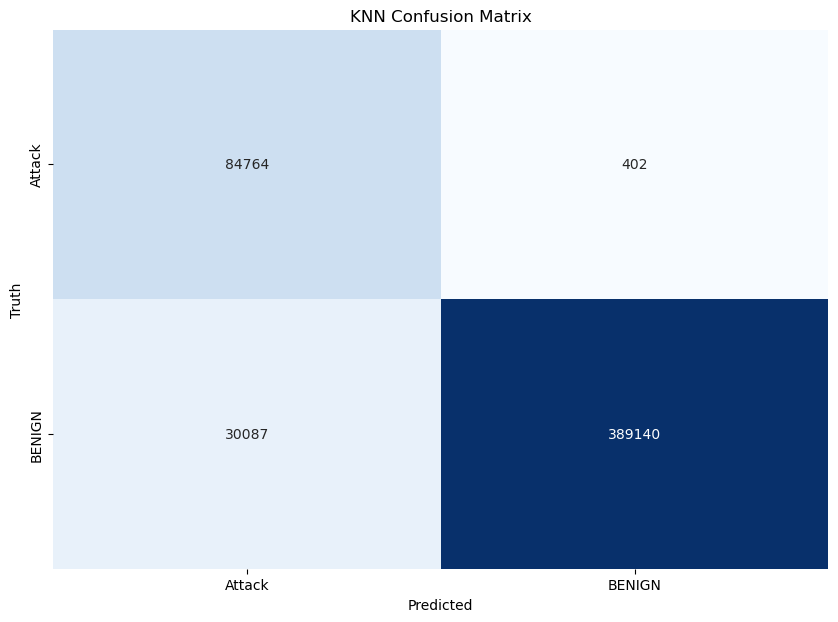

In [59]:
# Evaluating the model via confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('KNN Confusion Matrix')
plt.show()

In [60]:
### Classification Report

In [61]:
# Classification report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

      Attack       0.74      1.00      0.85     85166
      BENIGN       1.00      0.93      0.96    419227

    accuracy                           0.94    504393
   macro avg       0.87      0.96      0.90    504393
weighted avg       0.95      0.94      0.94    504393



In [62]:
## 2.3.3. Exporting model

In [63]:
joblib.dump(knn_model, '/home/wahba/Documents/nids5/test/model/binary/knn_binary.joblib')

['/home/wahba/Documents/nids5/test/model/binary/knn_binary.joblib']

In [64]:
# 3. Model Comparisons

In [65]:
# Calculating precision, recall, and F1 score for each model
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

precision_xgb = precision_score(y_test_mapped, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_mapped, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_mapped, y_pred_xgb, average='weighted')

precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

In [66]:
# Creating the results dataframe
supervised_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'KNN'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_knn],
    'Cross Validation Mean': [cv_scores_mean_rf, cv_scores_mean_xgb, cv_scores_mean_knn],
    'Precision': [precision_rf, precision_xgb, precision_knn],
    'Recall': [recall_rf, recall_xgb, recall_knn],
    'F1 Score': [f1_rf, f1_xgb, f1_knn],
    'Memory Usage (MB)': [measurement_rf['Memory Usage (MB)'], measurement_xgb['Memory Usage (MB)'], measurement_knn['Memory Usage (MB)']],
    'Training Time (s)': [measurement_rf['Training Time (s)'], measurement_xgb['Training Time (s)'], measurement_knn['Training Time (s)']],
    'Peak CPU Usage (%)': [measurement_rf['Peak CPU Usage (%)'], measurement_xgb['Peak CPU Usage (%)'], measurement_knn['Peak CPU Usage (%)']],
    'Average CPU Usage (%)': [measurement_rf['Average CPU Usage (%)'], measurement_xgb['Average CPU Usage (%)'], measurement_knn['Average CPU Usage (%)']],
})

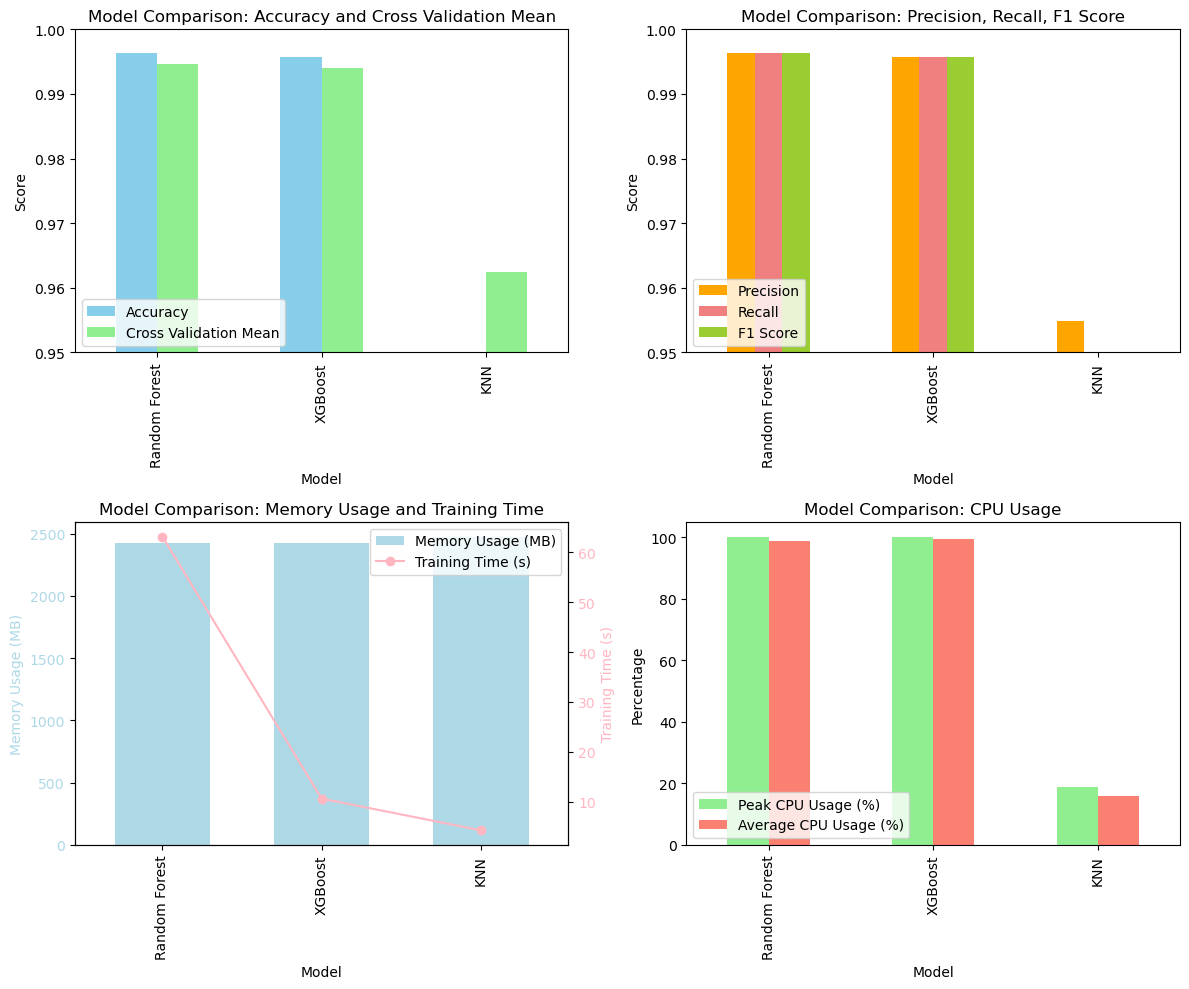

In [67]:
# Plotting the comparison for accuracy, cross-validation, and metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting Accuracy and Cross Validation Mean
supervised_results.set_index('Model')[['Accuracy', 'Cross Validation Mean']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightgreen'], legend=True)
axes[0, 0].set_title('Model Comparison: Accuracy and Cross Validation Mean')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylim(0.95, 1.0)
axes[0, 0].legend(loc='lower left')

# Plotting Precision, Recall, F1 Score
supervised_results.set_index('Model')[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axes[0, 1], color=['orange', 'lightcoral', 'yellowgreen'], legend=True)
axes[0, 1].set_title('Model Comparison: Precision, Recall, F1 Score')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylim(0.95, 1.0)
axes[0, 1].legend(loc='lower left')

# Plotting Memory Usage and Training Time
ax1 = axes[1, 0]

supervised_results.set_index('Model')['Memory Usage (MB)'].plot(
    kind='bar', ax=ax1, color='lightblue', label='Memory Usage (MB)', width=0.6
)
ax1.set_ylabel('Memory Usage (MB)', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')

ax2 = ax1.twinx() 
supervised_results.set_index('Model')['Training Time (s)'].plot(
    ax=ax2, color='lightpink', marker='o', label='Training Time (s)'
)
ax2.set_ylabel('Training Time (s)', color='lightpink')
ax2.tick_params(axis='y', labelcolor='lightpink')

ax1.set_title('Model Comparison: Memory Usage and Training Time')
ax1.set_xlabel('Model')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Plotting Peak and Average CPU Usage
supervised_results.set_index('Model')[['Peak CPU Usage (%)', 'Average CPU Usage (%)']].plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'], legend=True)
axes[1, 1].set_title('Model Comparison: CPU Usage')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Model')
axes[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()